# Implementation of collaborative filtering.

Two main approaches are used:
* Item-based;
* User-based.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import scipy
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix, csr_matrix
# import ipyplot

from io import BytesIO
from PIL import Image
# from IPython.display import Image, display
import requests
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
# import gensim
from scipy.sparse import coo_matrix, csr_matrix, diags
from scipy.sparse.linalg import svds

## Data preparation

In [17]:
interactions = pd.read_csv("../data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("../data/BX-Books.csv", low_memory=False)
users = pd.read_csv("../data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [23]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [24]:

interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "score",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [25]:
interactions = interactions[interactions["item_name"].notna()]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

## Utils

Some functions for viewing results.

In [50]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36"
}

def chunks(l, n):
    """Generator that returns chunks."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(
    product_ids,
    content_dict,
    measure=None,
    top_n=5
) -> None:
    """Renders multiple images."""
    picture_urls = [content_dict[i]["image_url"] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i, headers=headers)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}\n{}...".format(np.round(measure[cnt], 4), content_dict[product_ids[cnt]]["name"][:30]))
                cnt += 1
            else:
                a.title.set_text(content_dict[product_ids[cnt]]["name"])
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

## Model

In [30]:
class Colloborative():
    def __init__(self, interactions):
        self.content_dict = {}
        self.interactions = interactions

        # Filter interactions with score > 0
        self.interactions = self.interactions[self.interactions["score"] > 0]
        self.interactions["item_id"] = le.fit_transform(self.interactions["item_id"])
        self.interactions["user_id"] = le.fit_transform(self.interactions["user_id"])

        # Fill dict with content
        for i, j, k in self.interactions[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

        # Create matrix in COO format
        self.coo_rates: coo_matrix = coo_matrix(
            (
                self.interactions["score"],
                (self.interactions["user_id"], self.interactions["item_id"])
            ),
            shape=(len(set(self.interactions["user_id"])), len(set(self.interactions["item_id"])))
        )
        
    def show_book_names(self, list_of_ids, measure=None):
        for i in range(len(list_of_ids)):
            item_id = list_of_ids[i]
            if measure is not None:
                print(f"{np.round(measure[i], 2)}, ({item_id}) {self.content_dict[item_id]}")
            else:
                print(f" - {self.content_dict[item_id]}")

    def user_based(self, idx):
        mask = (self.coo_rates.getrow(idx).toarray()[0] > 0)

        # Get (un-)watched item indices
        watched_items = np.where(mask == True)[0]
        unwatched_items = np.where(mask == False)[0]
        # Convert to CSR format
        csr_rates = self.coo_rates.tocsr()

        # Get matrix of ratings for (un-)watched items
        watched_matrix = csr_rates[:, watched_items]
        unwatched_matrix = csr_rates[:, unwatched_items]

        # Compute mean user ratings of watched items
        mean_rates = watched_matrix.mean(axis=1)

        # Compute modifired rates of watched items as diff between user-item rate and mean user rate
        if watched_items.shape[0] == 1:
            # In case user had only one interaction, don't subtract mean to find similar users later
            modified_rates = watched_matrix.toarray()
            user_rates = modified_rates[idx].reshape(-1, 1)
        else:
            modified_rates = watched_matrix - mean_rates
            user_rates = modified_rates[idx]
        assert modified_rates.shape[1] == watched_items.shape[0], "Watched item ratings shape mismatch."

        # Get modified rates of user
        user_mean_rate = mean_rates[idx]
        
        # Compute similarity
        sim = cosine_similarity(
            np.array(user_rates),
            np.array(modified_rates) 
        )
        nonzero_sim_row_ids = np.argwhere(sim[0] > 0).flatten()
        rate_diff = unwatched_matrix[nonzero_sim_row_ids] - mean_rates[nonzero_sim_row_ids]

        rates = user_mean_rate + (sim[sim > 0] * rate_diff) / np.abs(sim).sum()

        top_recs = np.array(rates).flatten().argsort()[-10:][::-1]
        measure = sorted(np.array(rates).flatten())[-10:][::-1]
        self.get_rec(watched_items, top_recs, measure)

    def cosine_item_based(self, idx):
        mask = (self.coo_rates.getcol(idx).toarray() > 0).flatten()

        # Get users that rated target item
        row_ids_with_rating = np.where(mask == True)[0]

        csc_rates = self.coo_rates.tocsc()

        rows_with_rating = csc_rates[row_ids_with_rating].toarray()

        target_item_rates = rows_with_rating[:, idx].reshape(1, -1)

        sim = cosine_similarity(
            np.array(target_item_rates),
            np.array(rows_with_rating.T)
        ).T

        rates = rows_with_rating.T * sim

        rates = np.array(np.sum(rates, axis=1)).flatten()

        rates /= np.abs(sim).sum()

        top_recs = np.array(rates).flatten().argsort()[-10:][::-1]
        measure = sorted(np.array(rates).flatten())[-10:][::-1]
        self.get_rec([idx], top_recs, measure)
        
    def adjusted_cosine_item_based(self, idx):
        mask = (self.coo_rates.getcol(idx).toarray() > 0).flatten()

        # Get users who rated target item 
        row_ids_with_rating = np.where(mask == True)[0]
        csc_rates = self.coo_rates.tocsc()

        rows_with_rating = csc_rates[row_ids_with_rating].toarray()

        # Compute mean item ratings over users
        mean_item_rates = rows_with_rating.mean(axis=0)

        if row_ids_with_rating.shape[0] == 1:
            modified_rates = rows_with_rating
        else:
            modified_rates = rows_with_rating - mean_item_rates
        # target_item_rates = modified_rates[:, idx].reshape(1, -1)
        target_item_rates = rows_with_rating[:, idx].reshape(1, -1)

        # Get all modified item rates
        sim = cosine_similarity(
            np.array(target_item_rates),
            np.array(rows_with_rating.T)
        ).T
        # Get ids of values which are more than zero in similarity
        rates = modified_rates.T * sim

        rates = np.array(np.sum(rates, axis=1)).flatten()

        rates /= np.abs(sim).sum()

        rates += mean_item_rates

        top_recs = np.array(rates).flatten().argsort()[-10:][::-1]
        measure = sorted(np.array(rates).flatten())[-10:][::-1]
        self.get_rec([idx], top_recs, measure)

    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging(watched, self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(recs, self.content_dict, measure)

In [31]:
model = Colloborative(interactions)

C:\Users\cryst\AppData\Local\Temp\ipykernel_2560\4198980686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.interactions["item_id"] = le.fit_transform(self.interactions["item_id"])
C:\Users\cryst\AppData\Local\Temp\ipykernel_2560\4198980686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.interactions["user_id"] = le.fit_transform(self.interactions["user_id"])


## Check recommendations

### User-based

Для таких товаров


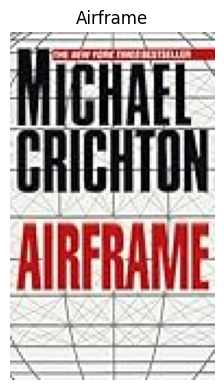

Такие рекомендации


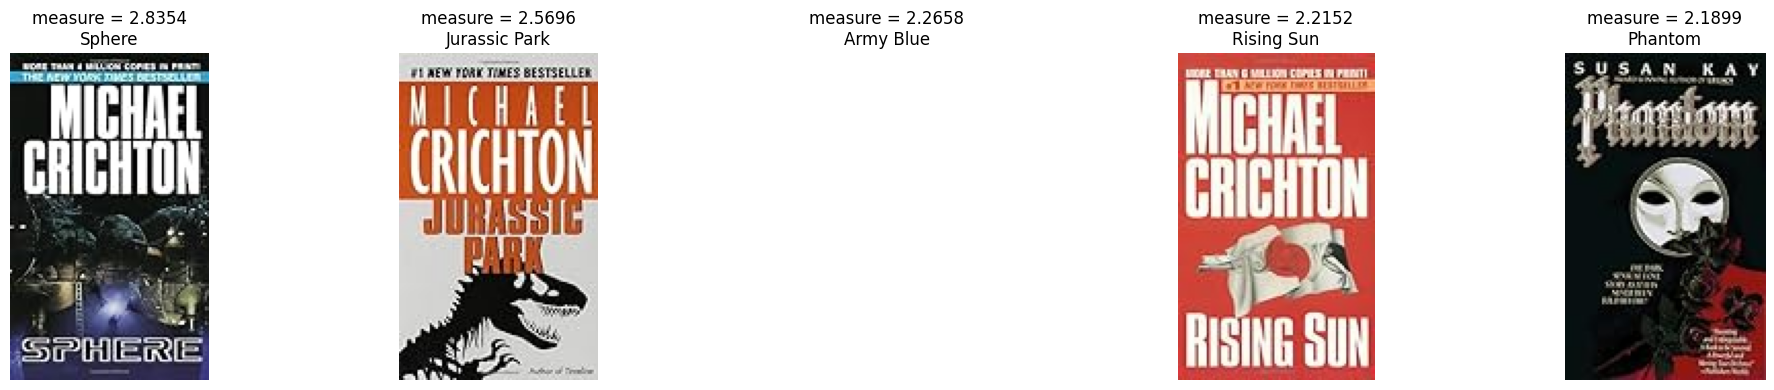

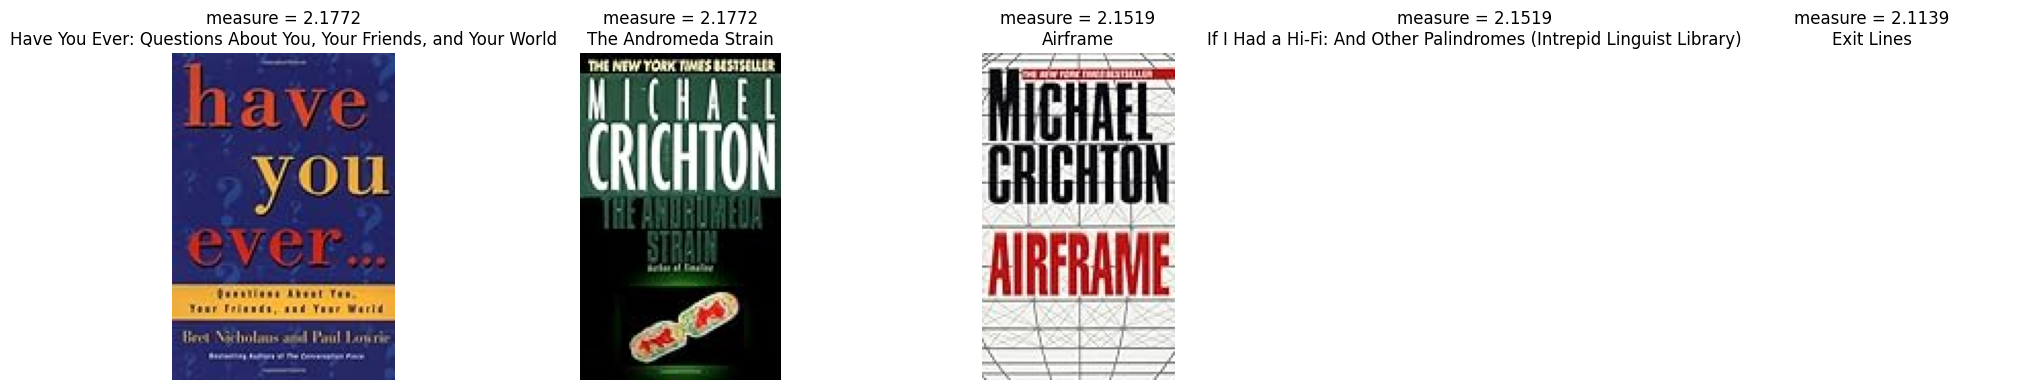

In [35]:
model.user_based(4)

### Item-based

First, let's find some popular books, such as "Harry Potter", "Hobbit".
Then recommendations are checked.

In [41]:
(
    model.interactions
    [model.interactions["item_name"].str.contains("The Lord of the Rings")]
    [["item_id", "item_name"]]
    .drop_duplicates()
    .head(5)
)

item_id                                          item_name
2831     24535  The Hobbit : The Enchanting Prelude to The Lor...
4130     71588  The Fellowship of the Ring (The Lord of the Ri...
9048     24536  The Fellowship of the Ring (The Lord of the Ri...
10285    71459  The Fellowship of the Ring (The Lord of the Ri...
11087    24537     The Two Towers (The Lord of the Rings, Part 2)

In [42]:
(
    model.interactions
    [model.interactions["item_name"].str.contains("Harry Potter")]
    [["item_id", "item_name"]]
    .drop_duplicates()
    .head(5)
)

item_id                                          item_name
84     46425  Harry Potter and the Order of the Phoenix (Boo...
210   143313              Harry Potter und der Stein der Weisen
211   143314         Harry Potter und die Kammer des Schreckens
212   143315         Harry Potter und der Gefangene von Azkaban
213   143316                    Harry Potter Und Der Feuerkelch

In [43]:
HARRY_ID = 46425
HOBBIT_ID = 24535

Now let's check item-based recommendations with popular books.

Для таких товаров


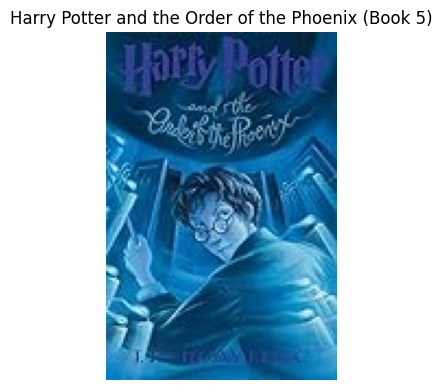

Такие рекомендации


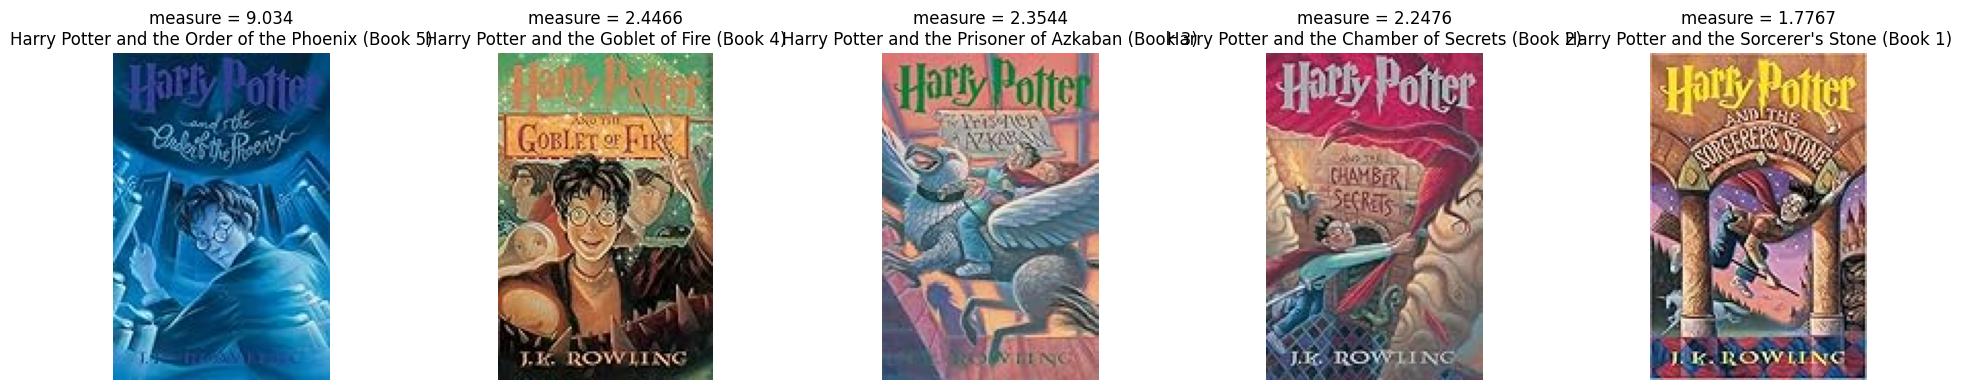

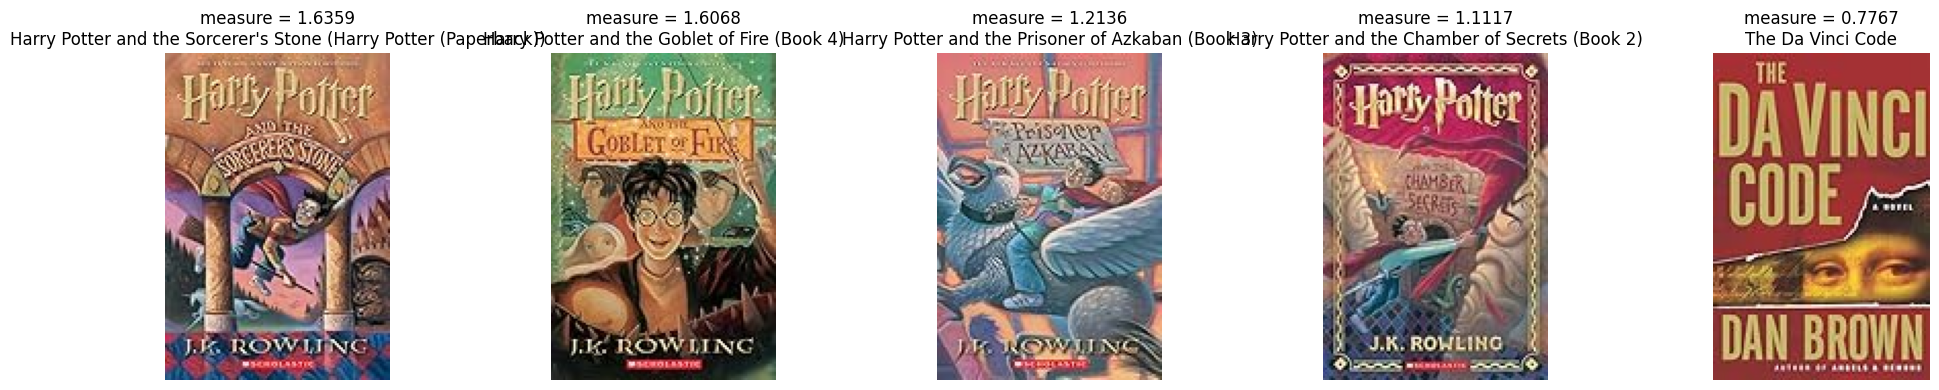

In [44]:
model.adjusted_cosine_item_based(HARRY_ID)

Для таких товаров


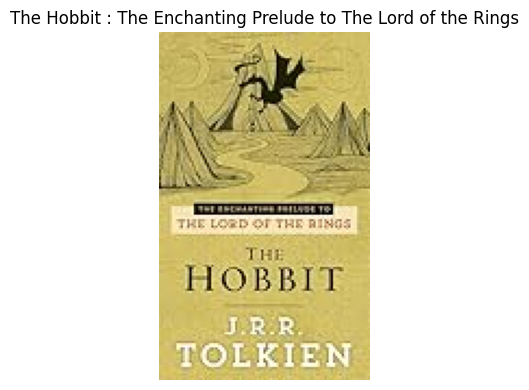

Такие рекомендации


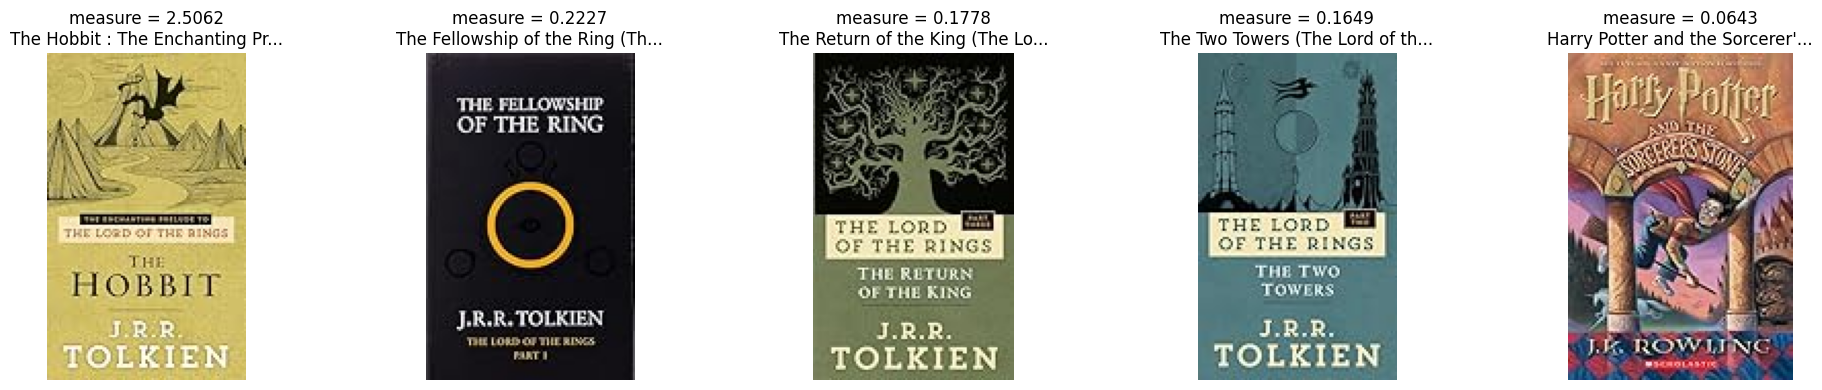

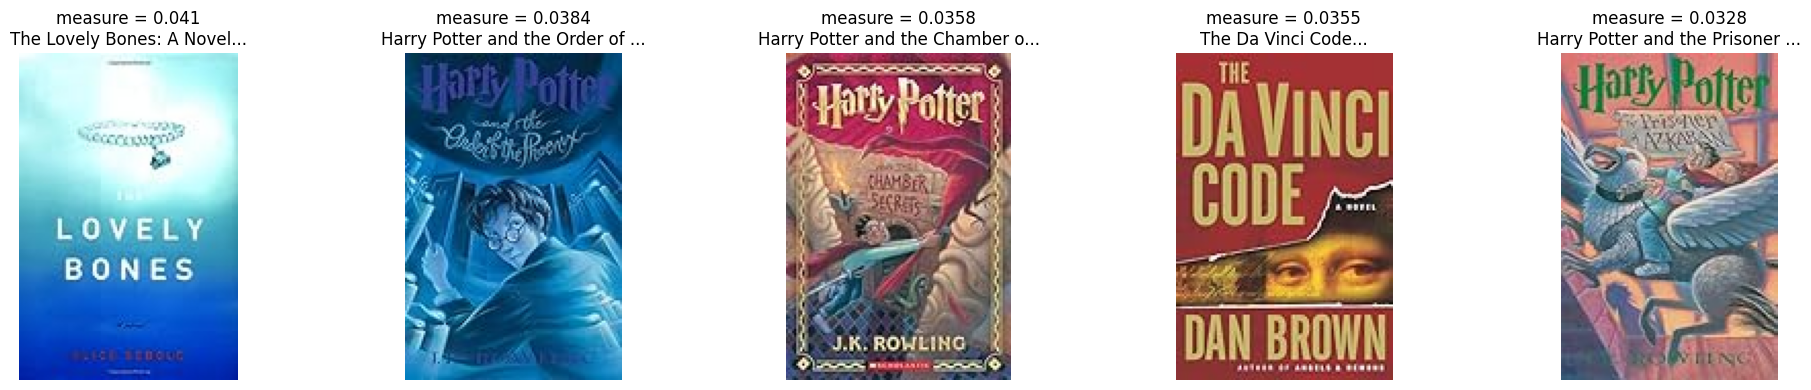

In [51]:
model.cosine_item_based(HOBBIT_ID)